In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import os
from ccfj import GetStationPairs
from geopy.distance import great_circle
from scipy.interpolate import interp1d
from scipy.interpolate import griddata

In [3]:
import sys
sys.path.append(r'../')
from toollib_standard import plotlib

In [4]:
proj_name = 'output_FJSJ_09-07/'
filename_basic = proj_name+'Basic_info.npy'
info_basic = np.load(filename_basic, allow_pickle='TRUE').item()
dir_image = info_basic['dir_image']
dir_inv_dispernet = info_basic['dir_inv_dispernet']
key_subworks = info_basic['key_subworks']
M = len(key_subworks)
key_subworks

['07-03',
 '10-03',
 '13-03',
 '16-03',
 '19-03',
 '22-03',
 '25-03',
 '28-03',
 '31-03',
 '34-03',
 '37-03',
 '40-03',
 '43-03',
 '46-03',
 '49-03',
 '52-03',
 '07-04',
 '10-04',
 '13-04',
 '16-04',
 '19-04',
 '22-04',
 '25-04',
 '28-04',
 '31-04',
 '34-04',
 '37-04',
 '40-04',
 '43-04',
 '46-04',
 '49-04',
 '52-04',
 '07-05',
 '10-05',
 '13-05',
 '16-05',
 '19-05',
 '22-05',
 '25-05',
 '28-05',
 '31-05',
 '34-05',
 '37-05',
 '40-05',
 '43-05',
 '46-05',
 '49-05',
 '52-05',
 '07-06',
 '10-06',
 '13-06',
 '16-06',
 '19-06',
 '22-06',
 '25-06',
 '28-06',
 '31-06',
 '34-06',
 '37-06',
 '40-06',
 '43-06',
 '46-06',
 '49-06',
 '52-06',
 '07-07',
 '10-07',
 '13-07',
 '16-07',
 '19-07',
 '22-07',
 '25-07',
 '28-07',
 '31-07',
 '34-07',
 '37-07',
 '40-07',
 '43-07',
 '46-07',
 '49-07',
 '52-07',
 '07-08',
 '10-08',
 '13-08',
 '16-08',
 '19-08',
 '22-08',
 '25-08',
 '28-08',
 '31-08',
 '34-08',
 '37-08',
 '40-08',
 '43-08',
 '46-08',
 '49-08',
 '52-08',
 '07-09',
 '10-09',
 '13-09',
 '16-09',


In [5]:
struc = {}
flag = 0
file_struc = dir_inv_dispernet + 'structure_model.xlsx'
df = pd.read_excel(file_struc,sheet_name=None)
for key_subwork in key_subworks:
    struc[key_subwork] = df[key_subwork]
    flag += 1
    print('Read structure model: %s (%d/%d)' % (key_subwork, flag, M))
dz = 4

Read structure model: 07-03 (1/256)
Read structure model: 10-03 (2/256)
Read structure model: 13-03 (3/256)
Read structure model: 16-03 (4/256)
Read structure model: 19-03 (5/256)
Read structure model: 22-03 (6/256)
Read structure model: 25-03 (7/256)
Read structure model: 28-03 (8/256)
Read structure model: 31-03 (9/256)
Read structure model: 34-03 (10/256)
Read structure model: 37-03 (11/256)
Read structure model: 40-03 (12/256)
Read structure model: 43-03 (13/256)
Read structure model: 46-03 (14/256)
Read structure model: 49-03 (15/256)
Read structure model: 52-03 (16/256)
Read structure model: 07-04 (17/256)
Read structure model: 10-04 (18/256)
Read structure model: 13-04 (19/256)
Read structure model: 16-04 (20/256)
Read structure model: 19-04 (21/256)
Read structure model: 22-04 (22/256)
Read structure model: 25-04 (23/256)
Read structure model: 28-04 (24/256)
Read structure model: 31-04 (25/256)
Read structure model: 34-04 (26/256)
Read structure model: 37-04 (27/256)
Read struc

In [6]:
stalistname = info_basic['stalistname']
stainfo = pd.read_excel(stalistname+'.xlsx')
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_all =  stainfo['latitude'].tolist() 
lon_all =  stainfo['longitude'].tolist() 

### Plot 2D with certain depth

In [7]:
N = 99

vs_all = np.zeros(len(key_subworks))
lats_all = np.zeros(len(key_subworks))
lons_all = np.zeros(len(key_subworks))

rows = []
cols = []

for i in range(len(key_subworks)):
    key_subwork = key_subworks[i]
    key = 'R' +  key_subwork[0:2]+key_subwork[3:5]
    rows.append(int(key_subwork[3:5]))
    cols.append(int(key_subwork[0:2]))
    if key in stalist_all:
        indx = stalist_all.index(key)
        lats_all[i] = lat_all[indx]
        lons_all[i] = lon_all[indx]
        vs_all[i] = struc[key_subwork]['vs'].tolist()[N]
    else:
        key1 = 'R' + str(int(key_subwork[0:2])-1).zfill(2)+key_subwork[3:5]
        key2 = 'R' + str(int(key_subwork[0:2])+1).zfill(2)+key_subwork[3:5]
        indx1 = stalist_all.index(key1)
        indx2 = stalist_all.index(key2)
        lats_all[i] = (lat_all[indx1]+lat_all[indx2])/2
        lons_all[i] = (lon_all[indx1]+lon_all[indx2])/2
        vs_all[i] = struc[key_subwork]['vs'].tolist()[N]

rows_flag = set(np.sort(rows))
cols_flag = set(np.sort(cols))
# 进行二维插值



In [8]:
vs = np.zeros((len(rows_flag),len(cols_flag)))
lats = np.zeros((len(rows_flag),len(cols_flag)))
lons = np.zeros((len(rows_flag),len(cols_flag)))
for i in range(len(rows_flag)):
    for j in range(len(cols_flag)):
        indx = i*len(cols_flag)+j
        vs[i,j] = vs_all[indx]
        lats[i,j] = lats_all[indx]
        lons[i,j] = lons_all[indx]

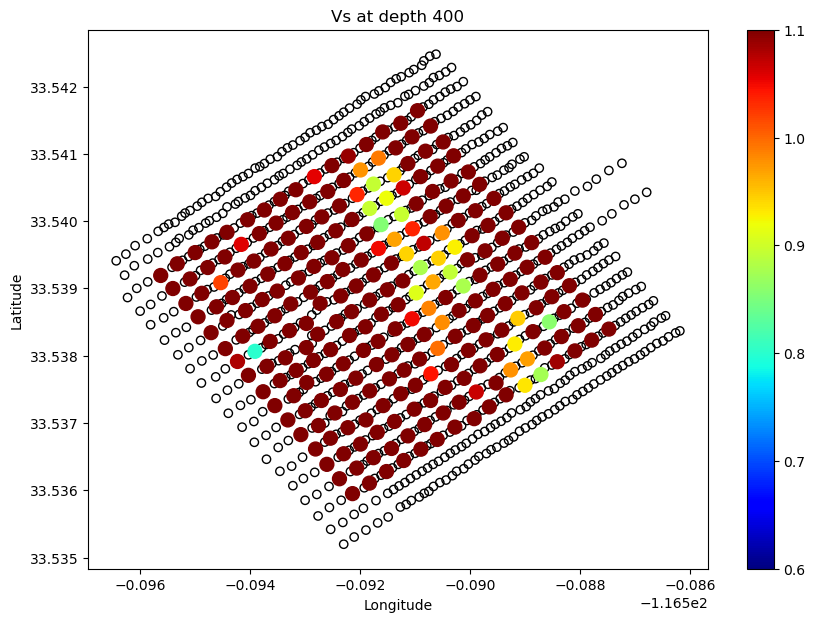

In [9]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
c_min = 0.6
c_max = 1.1
# background
ax.scatter(lon_all, lat_all,marker='o',color='none',edgecolors='k')
#ax.set_xticks([])  #去掉横坐标值
#ax.set_yticks([])  #去掉纵坐标值
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Vs at depth '+str((N+1)*dz))
# Vs plot
cbar = np.linspace(c_min,c_max,20)
plt.scatter(lons,lats,c=vs,cmap='jet',vmin=c_min, vmax=c_max, s = 100)
plt.colorbar()

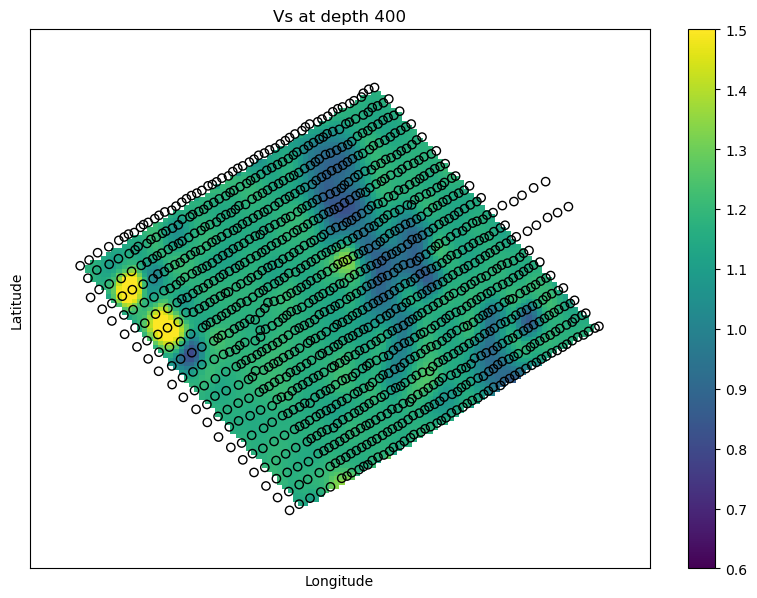

In [40]:
xi = np.linspace(min(lons_all),max(lons_all),100)
yi = np.linspace(min(lats_all),max(lats_all),100)
# grid the data
zi = griddata((lons_all, lats_all), vs_all, (xi[None,:], yi[:,None]), method='cubic')

fig,ax = plt.subplots(1,1,figsize=(10,7))
c_min = 0.6
c_max = 1.5
# background
ax.scatter(lon_all, lat_all,marker='o',color='none',edgecolors='k')
ax.set_xticks([])  #去掉横坐标值
ax.set_yticks([])  #去掉纵坐标值
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Vs at depth '+str((N+1)*dz))
flag_add = 0.001
ax.set_xlim([min(lon_all)-flag_add, max(lon_all)+flag_add])
ax.set_ylim([min(lat_all)-flag_add, max(lat_all)+flag_add])
# Vs plot
cbar = np.linspace(c_min,c_max,20)
im = ax.imshow(zi, vmin=c_min, vmax=c_max, origin='lower', extent=[min(lon_all), max(lon_all), min(lat_all), max(lat_all)], aspect='auto')
plt.colorbar(im)

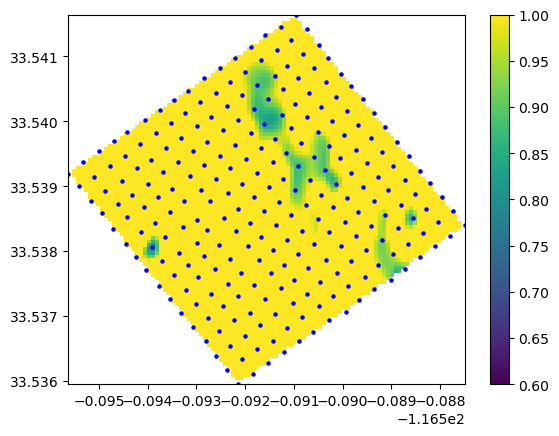

In [19]:
# 使用griddata进行二维散点插值
#from scipy.integrate import griddata
# 生成网格数据
xi = np.linspace(min(lons_all),max(lons_all),100)
yi = np.linspace(min(lats_all),max(lats_all),100)
# grid the data
zi = griddata((lons_all, lats_all), vs_all, (xi[None,:], yi[:,None]), method='cubic')
# contour the gridded data, plotting dots at the randomly spaced data points.
#CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet,vmin=c_min, vmax=c_max)
im = plt.imshow(zi, vmin=c_min, vmax=c_max, origin='lower', extent=[min(xi), max(xi), min(yi), max(yi)], aspect='auto')
plt.colorbar() # draw colorbar
# plot data points.
plt.scatter(lons_all,lats_all,marker='o',c='b',s=5)

### Do clipper

In [66]:
def extract_verticle(row_tag,N,M,key_subworks):
    key_subworks_lists = []
    rows = []
    cols = []
    for key_subwork in key_subworks:
        row = key_subwork[3:5]
        col = key_subwork[0:2] 
        if row == str(row_tag):
            key_subworks_lists.append(key_subwork)
            rows.append(row)
            cols.append(col)
    
    # 根据行号排序
    rows = np.array(rows)
    cols = np.array(cols)
    indx = np.argsort(cols)
    rows = rows[indx]
    cols = cols[indx]
    key_subworks_lists = np.array(key_subworks_lists)
    key_subworks_lists = key_subworks_lists[indx]

    vs = np.zeros((len(key_subworks_lists),N))
    rs = np.zeros(len(key_subworks_lists))
    
    # 定义起始点的坐标
    key_start = 'R' + cols[0] + rows[0]
    if key_start in stalist_all:
        indx = stalist_all.index(key_start)
        lat_start = lat_all[indx]
        lon_start = lon_all[indx]
    else:
        key1 = 'R' + str(int(cols[0])-1).zfill(2)+rows[0]
        key2 = 'R' + str(int(cols[0])+1).zfill(2)+rows[0]
        indx1 = stalist_all.index(key1)
        indx2 = stalist_all.index(key2)
        lat_start = (lat_all[indx1]+lat_all[indx2])/2
        lon_start = (lon_all[indx1]+lon_all[indx2])/2

    # 算r
    flag_this = 0
    for key_subwork in key_subworks_lists:
        key = 'R' +  key_subwork[0:2]+key_subwork[3:5]
        
        if key in stalist_all:
            indx = stalist_all.index(key)
            rs[flag_this] = great_circle((lat_start,lon_start),(lat_all[indx],lon_all[indx])).m
            vs[flag_this,:] = struc[key_subwork]['vs'].tolist()
        else:
            key1 = 'R' + str(int(key_subwork[0:2])-1).zfill(2)+key_subwork[3:5]
            key2 = 'R' + str(int(key_subwork[0:2])+1).zfill(2)+key_subwork[3:5]
            indx1 = stalist_all.index(key1)
            indx2 = stalist_all.index(key2)
            lat_this = (lat_all[indx1]+lat_all[indx2])/2
            lon_this = (lon_all[indx1]+lon_all[indx2])/2
            rs[flag_this] = great_circle((lat_start,lon_start),(lat_this,lon_this)).m
            vs[flag_this,:] = struc[key_subwork]['vs'].tolist()
        flag_this += 1
    vs = np.array(vs)

    # 插值
    vs_interp = np.zeros((M*len(rs),N))
    for i in range(N):
        f = interp1d(rs, vs[:,i], kind='cubic')
        vs_interp[:,i] = f(np.linspace(0,rs[-1],M*len(rs)))
    return vs_interp,np.linspace(0,rs[-1],M*len(rs))

In [67]:
%%capture
N = 100
M = 20
c_min = 0.4
c_max = 1.3
for i in range(3,19):
#for i in range(3,4):
    row_tag = str(i).zfill(2)
    vs,rs = extract_verticle(row_tag,N,M,key_subworks)
    fig,ax = plt.subplots(1,1,figsize=(12,6))
    im = ax.imshow(vs.T,aspect='auto',cmap='gist_rainbow',vmin=c_min, vmax=c_max,extent=[0,rs[-1],N*dz,0])
    ax.set_xlabel('Distance along the profile (m)')
    ax.set_ylabel('Depth (m)')
    ax.set_title('Vs profile at row '+row_tag)
    #在图中展示colorbar
    cbar = fig.colorbar(im)
    filename = dir_image + 'Vs_profile_row_'+row_tag+'.png'
    plt.savefig(filename,dpi=100)